In [1]:
import warnings
import pandas as pd
import plotly.express as px
import plotly.io as pio
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from matplotlib.colors import LinearSegmentedColormap
from sklearn.discriminant_analysis import StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import gridspec

In [2]:
INPUT_PATH = './input'
OUTPUT_PATH = './output'

INPUT_FILENAME = 'raw.csv'

DEFAULT_FIG_HEIGHT = 800

px.defaults.template = 'plotly_dark'

# pio.renderers.default = "notebook" 

# za graph preview na Github-u
png_renderer = pio.renderers["png"]
png_renderer.width = 1400
png_renderer.height = 500
pio.renderers.default = "png" 

warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [3]:
df = pd.read_csv(f'{INPUT_PATH}/{INPUT_FILENAME}', encoding='latin1')

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.rename(columns={'sub-category': 'sub_category'}, inplace=True)
df['order_date'] = pd.to_datetime(df['order_date'], format='%d-%m-%Y')
df['ship_date'] = pd.to_datetime(df['order_date'], format='%d-%m-%Y')
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05,2013-02-05,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,2013-10-17,2013-10-17,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,2013-01-28,2013-01-28,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,2013-11-05,2013-11-05,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,51290.0,25645.500000,14806.291990,1.000,12823.250000,25645.500,38467.7500,51290.000
postal_code,9994.0,55190.379428,32063.693350,1040.000,23223.000000,56430.500,90008.0000,99301.000
sales,51290.0,246.490581,487.565361,0.444,30.758625,85.053,251.0532,22638.480
quantity,51290.0,3.476545,2.278766,1.000,2.000000,3.000,5.0000,14.000
discount,51290.0,0.142908,0.212280,0.000,0.000000,0.000,0.2000,0.850
profit,51290.0,28.610982,174.340972,-6599.978,0.000000,9.240,36.8100,8399.976
shipping_cost,51290.0,26.375915,57.296804,0.000,2.610000,7.790,24.4500,933.570


In [6]:
df.describe(include='object').T

,count,unique,top,freq
order_id,51290,25035,CA-2014-100111,14
ship_mode,51290,4,Standard Class,30775
customer_id,51290,1590,PO-18850,97
customer_name,51290,795,Muhammed Yedwab,108
segment,51290,3,Consumer,26518
city,51290,3636,New York City,915
state,51290,1094,California,2001
country,51290,147,United States,9994
market,51290,7,APAC,11002
region,51290,13,Central,11117


In [7]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows.")

df.drop_duplicates(inplace=True)

The dataset contains 0 duplicate rows.


In [8]:
df.reset_index(drop=True, inplace=True)
df.shape[0]

51290

###  Feature Engineering

#### Recency 

In [9]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_day'] = df['order_date'].dt.date

customer_data = df.groupby('customer_id')['order_day'].max().reset_index()

most_recent_date = df['order_day'].max()

customer_data['order_day'] = pd.to_datetime(customer_data['order_day'])
most_recent_date = pd.to_datetime(most_recent_date)

customer_data['days_since_last_purchase'] = (most_recent_date - customer_data['order_day']).dt.days

customer_data.drop(columns=['order_day'], inplace=True)
customer_data.head()

,customer_id,days_since_last_purchase
0,AA-10315,8
1,AA-10375,6
2,AA-10480,125
3,AA-10645,28
4,AA-315,2


#### Frequency

In [10]:
total_transactions = df.groupby('customer_id')['order_id'].nunique().reset_index()
total_transactions.rename(columns={'order_id': 'total_transactions'}, inplace=True)

total_products_purchased = df.groupby('customer_id')['quantity'].sum().reset_index()
total_products_purchased.rename(columns={'quantity': 'total_products_purchased'}, inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='customer_id')
customer_data = pd.merge(customer_data, total_products_purchased, on='customer_id')
customer_data.head()

,customer_id,days_since_last_purchase,total_transactions,total_products_purchased
0,AA-10315,8,19,145
1,AA-10375,6,23,139
2,AA-10480,125,20,150
3,AA-10645,28,36,267
4,AA-315,2,7,20


#### Monetary 

In [11]:
total_spend = df.groupby('customer_id')['sales'].sum().reset_index()

average_transaction_value = total_spend.merge(total_transactions, on='customer_id')
average_transaction_value['average_transaction_value'] = average_transaction_value['sales'] / average_transaction_value['total_transactions']

customer_data = pd.merge(customer_data, total_spend, on='customer_id')
customer_data = pd.merge(customer_data, average_transaction_value[['customer_id', 'average_transaction_value']], on='customer_id')

customer_data.head()

,customer_id,days_since_last_purchase,total_transactions,total_products_purchased,sales,average_transaction_value
0,AA-10315,8,19,145,13747.41300,723.548053
1,AA-10375,6,23,139,5884.19500,255.834565
2,AA-10480,125,20,150,17695.58978,884.779489
3,AA-10645,28,36,267,15343.89070,426.219186
4,AA-315,2,7,20,2243.25600,320.465143


#### Product Diversity

In [12]:
unique_products_purchased = df.groupby('customer_id')['product_id'].nunique().reset_index()
unique_products_purchased.rename(columns={'product_id': 'unique_products_purchased'}, inplace=True)

customer_data = pd.merge(customer_data, unique_products_purchased, on='customer_id')
customer_data.head()

,customer_id,days_since_last_purchase,total_transactions,total_products_purchased,sales,average_transaction_value,unique_products_purchased
0,AA-10315,8,19,145,13747.41300,723.548053,42
1,AA-10375,6,23,139,5884.19500,255.834565,42
2,AA-10480,125,20,150,17695.58978,884.779489,38
3,AA-10645,28,36,267,15343.89070,426.219186,73
4,AA-315,2,7,20,2243.25600,320.465143,8


#### Behavioral Features

In [13]:
df.sort_values(by='order_date', inplace=True)
df['day_of_week'] = df['order_date'].dt.dayofweek

days_between_purchases = df.groupby('customer_id')['order_day'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('customer_id').mean().reset_index()
average_days_between_purchases.rename(columns={'order_day': 'average_days_between_purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['customer_id', 'day_of_week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('customer_id')['Count'].idxmax()][['customer_id', 'day_of_week']]

customer_data = pd.merge(customer_data, average_days_between_purchases, on='customer_id')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='customer_id')
customer_data.head()

,customer_id,days_since_last_purchase,total_transactions,total_products_purchased,sales,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week
0,AA-10315,8,19,145,13747.41300,723.548053,42,33.243902,0
1,AA-10375,6,23,139,5884.19500,255.834565,42,32.780488,4
2,AA-10480,125,20,150,17695.58978,884.779489,38,32.756757,3
3,AA-10645,28,36,267,15343.89070,426.219186,73,19.541667,2
4,AA-315,2,7,20,2243.25600,320.465143,8,185.714286,3


###  Seasonality & Trends

In [14]:
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month

monthly_spending = df.groupby(['customer_id', 'year', 'month'])['sales'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('customer_id')['sales'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'monthly_spending_mean', 'std': 'monthly_spending_std'}, inplace=True)

seasonal_buying_patterns['monthly_spending_std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

spending_trends = monthly_spending.groupby('customer_id')['sales'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'sales': 'spending_trend'}, inplace=True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='customer_id')
customer_data = pd.merge(customer_data, spending_trends, on='customer_id')
customer_data.head()

,customer_id,days_since_last_purchase,total_transactions,total_products_purchased,sales,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,monthly_spending_mean,monthly_spending_std,spending_trend
0,AA-10315,8,19,145,13747.41300,723.548053,42,33.243902,0,859.213313,1297.341964,14.144729
1,AA-10375,6,23,139,5884.19500,255.834565,42,32.780488,4,309.694474,366.196502,8.913205
2,AA-10480,125,20,150,17695.58978,884.779489,38,32.756757,3,1105.974361,998.531086,85.520092
3,AA-10645,28,36,267,15343.89070,426.219186,73,19.541667,2,613.755628,677.040994,-1.422054
4,AA-315,2,7,20,2243.25600,320.465143,8,185.714286,3,373.876000,540.134998,-91.279543


In [15]:
customer_data['customer_id'] = customer_data['customer_id'].astype(str)
customer_data = customer_data.convert_dtypes()
customer_data.head(10)

,customer_id,days_since_last_purchase,total_transactions,total_products_purchased,sales,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,monthly_spending_mean,monthly_spending_std,spending_trend
0,AA-10315,8,19,145,13747.413,723.548053,42,33.243902,0,859.213313,1297.341964,14.144729
1,AA-10375,6,23,139,5884.195,255.834565,42,32.780488,4,309.694474,366.196502,8.913205
2,AA-10480,125,20,150,17695.58978,884.779489,38,32.756757,3,1105.974361,998.531086,85.520092
3,AA-10645,28,36,267,15343.8907,426.219186,73,19.541667,2,613.755628,677.040994,-1.422054
4,AA-315,2,7,20,2243.256,320.465143,8,185.714286,3,373.876,540.134998,-91.279543
5,AA-375,253,8,30,654.492,81.8115,13,88.0,4,81.8115,87.686882,5.088143
6,AA-480,314,5,25,2063.493,412.6986,10,108.333333,1,412.6986,405.801399,-130.1754
7,AA-645,51,11,35,1968.324,178.938545,18,76.352941,0,218.702667,164.117596,3.37105
8,AB-10015,16,32,268,20037.4975,626.171797,76,18.355263,0,801.4999,912.082912,35.59152
9,AB-10060,42,32,232,18416.5504,575.5172,56,25.214286,3,837.115927,1333.779171,34.586017


### Outlier Detection and Treatment

In [16]:
model = IsolationForest(contamination=0.05, random_state=0)

customer_data['outlier_scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

customer_data['is_outlier'] = [1 if x == -1 else 0 for x in customer_data['outlier_scores']]

customer_data.head()

,customer_id,days_since_last_purchase,total_transactions,total_products_purchased,sales,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,monthly_spending_mean,monthly_spending_std,spending_trend,outlier_scores,is_outlier
0,AA-10315,8,19,145,13747.413,723.548053,42,33.243902,0,859.213313,1297.341964,14.144729,1,0
1,AA-10375,6,23,139,5884.195,255.834565,42,32.780488,4,309.694474,366.196502,8.913205,1,0
2,AA-10480,125,20,150,17695.58978,884.779489,38,32.756757,3,1105.974361,998.531086,85.520092,1,0
3,AA-10645,28,36,267,15343.8907,426.219186,73,19.541667,2,613.755628,677.040994,-1.422054,1,0
4,AA-315,2,7,20,2243.256,320.465143,8,185.714286,3,373.876,540.134998,-91.279543,1,0


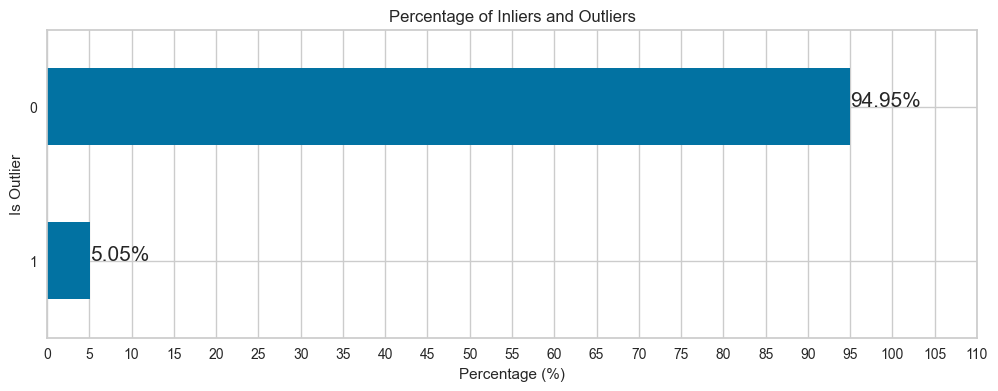

In [17]:
outlier_percentage = customer_data['is_outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [18]:
outliers_data = customer_data[customer_data['is_outlier'] == 1]

customer_data_cleaned = customer_data[customer_data['is_outlier'] == 0]

customer_data_cleaned = customer_data_cleaned.drop(columns=['outlier_scores', 'is_outlier'])

customer_data_cleaned.reset_index(drop=True, inplace=True)
customer_data_cleaned.shape[0]

1503

### Correlation Analysis

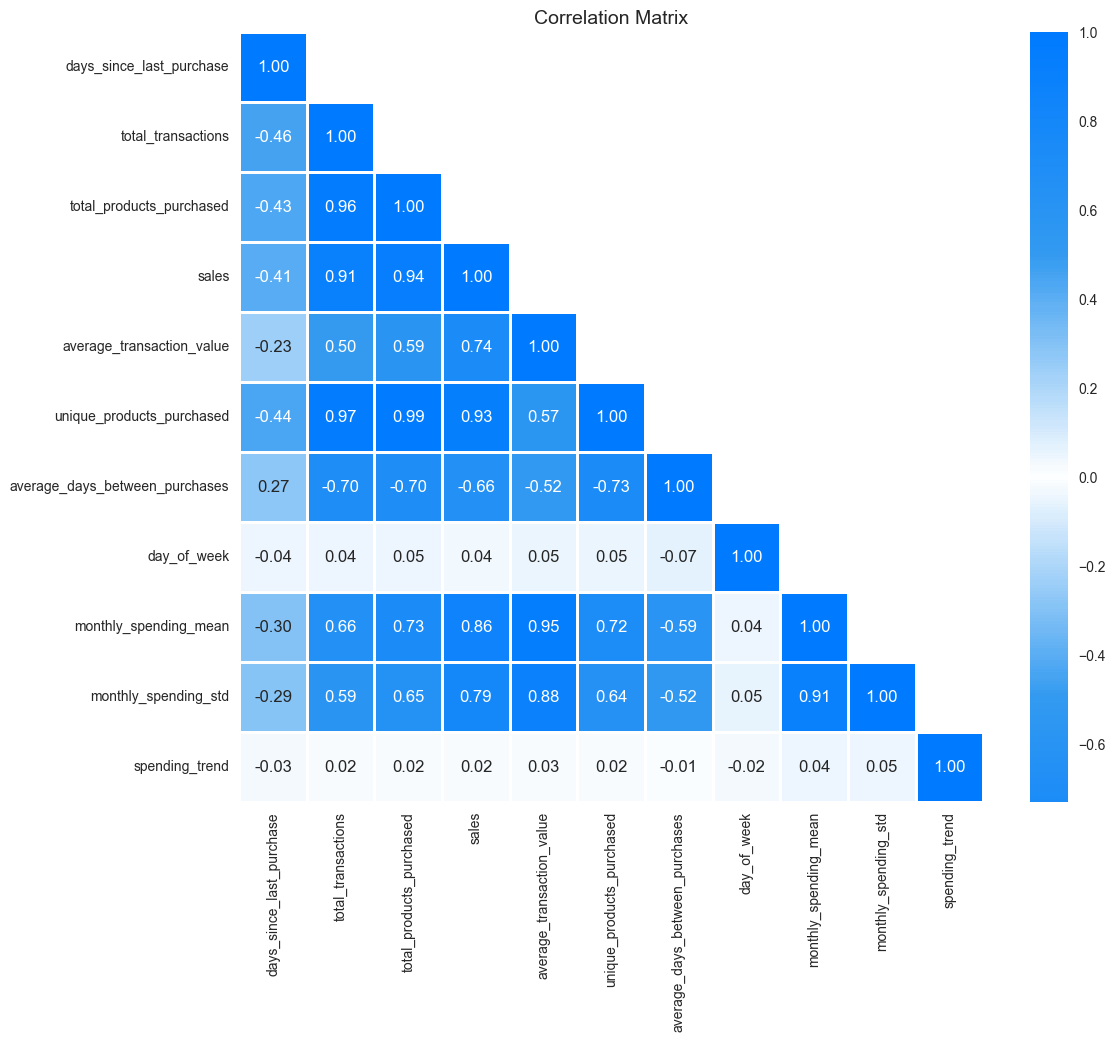

In [19]:
corr = customer_data_cleaned.drop(columns=['customer_id']).corr()

colors = ['#007bff', '#339af0', 'white', '#339af0', '#007bff']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### Feature Scaling

In [20]:
scaler = StandardScaler()

columns_to_exclude = ['customer_id', 'day_of_week']

columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

customer_data_scaled = customer_data_cleaned.copy()

customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

customer_data_scaled.head()

,customer_id,days_since_last_purchase,total_transactions,total_products_purchased,sales,average_transaction_value,unique_products_purchased,average_days_between_purchases,day_of_week,monthly_spending_mean,monthly_spending_std,spending_trend
0,AA-10315,-0.610680,0.246209,0.363709,0.919115,1.588505,0.455487,-0.560124,0,1.250714,1.624980,0.063836
1,AA-10375,-0.628550,0.629880,0.296160,-0.291326,-0.791263,0.455487,-0.568446,4,-0.754268,-0.686539,0.014551
2,AA-10480,0.434770,0.342127,0.420000,1.526886,2.408864,0.266607,-0.568872,3,2.151050,0.883198,0.736238
3,AA-10645,-0.431970,1.876814,1.737214,1.164872,0.075669,1.919311,-0.806171,2,0.355134,0.085116,-0.082813
4,AA-315,-0.664292,-0.904807,-1.043570,-0.851802,-0.462417,-1.149997,2.177742,3,-0.520095,-0.254746,-0.929329


### Dimensionality Reduction

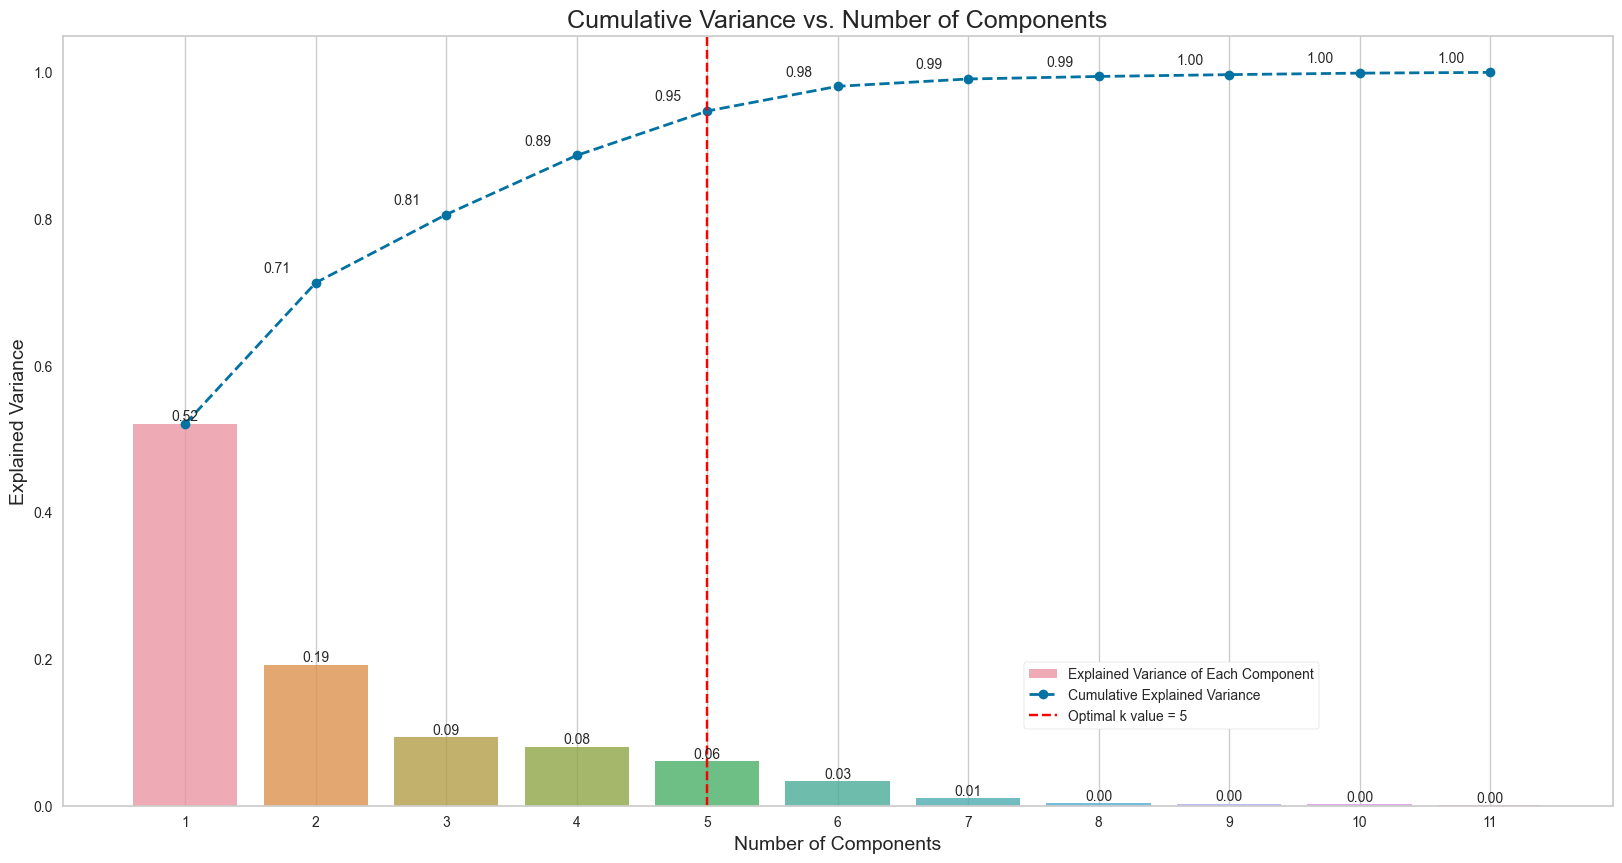

In [21]:
customer_data_scaled.set_index('customer_id', inplace=True)

pca = PCA().fit(customer_data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

optimal_k = 5

plt.figure(figsize=(20, 10))

barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      alpha=0.8)

lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--',  linewidth=2)

optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0)  

x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [22]:
pca = PCA(n_components=5)

customer_data_pca = pca.fit_transform(customer_data_scaled)

customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

customer_data_pca.index = customer_data_scaled.index

### K-Means Clustering

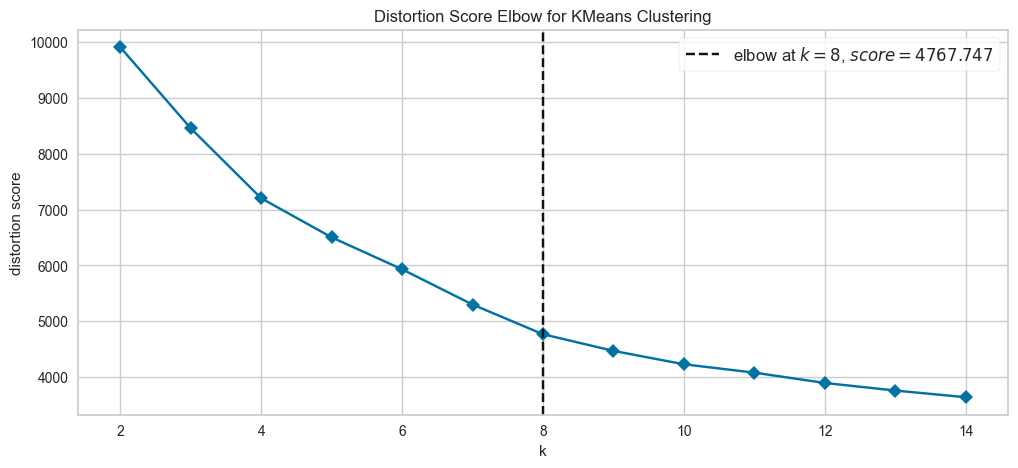

In [23]:
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

fig, ax = plt.subplots(figsize=(12, 5))

visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

visualizer.fit(customer_data_pca)

visualizer.show();

In [24]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    silhouette_scores = []

    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

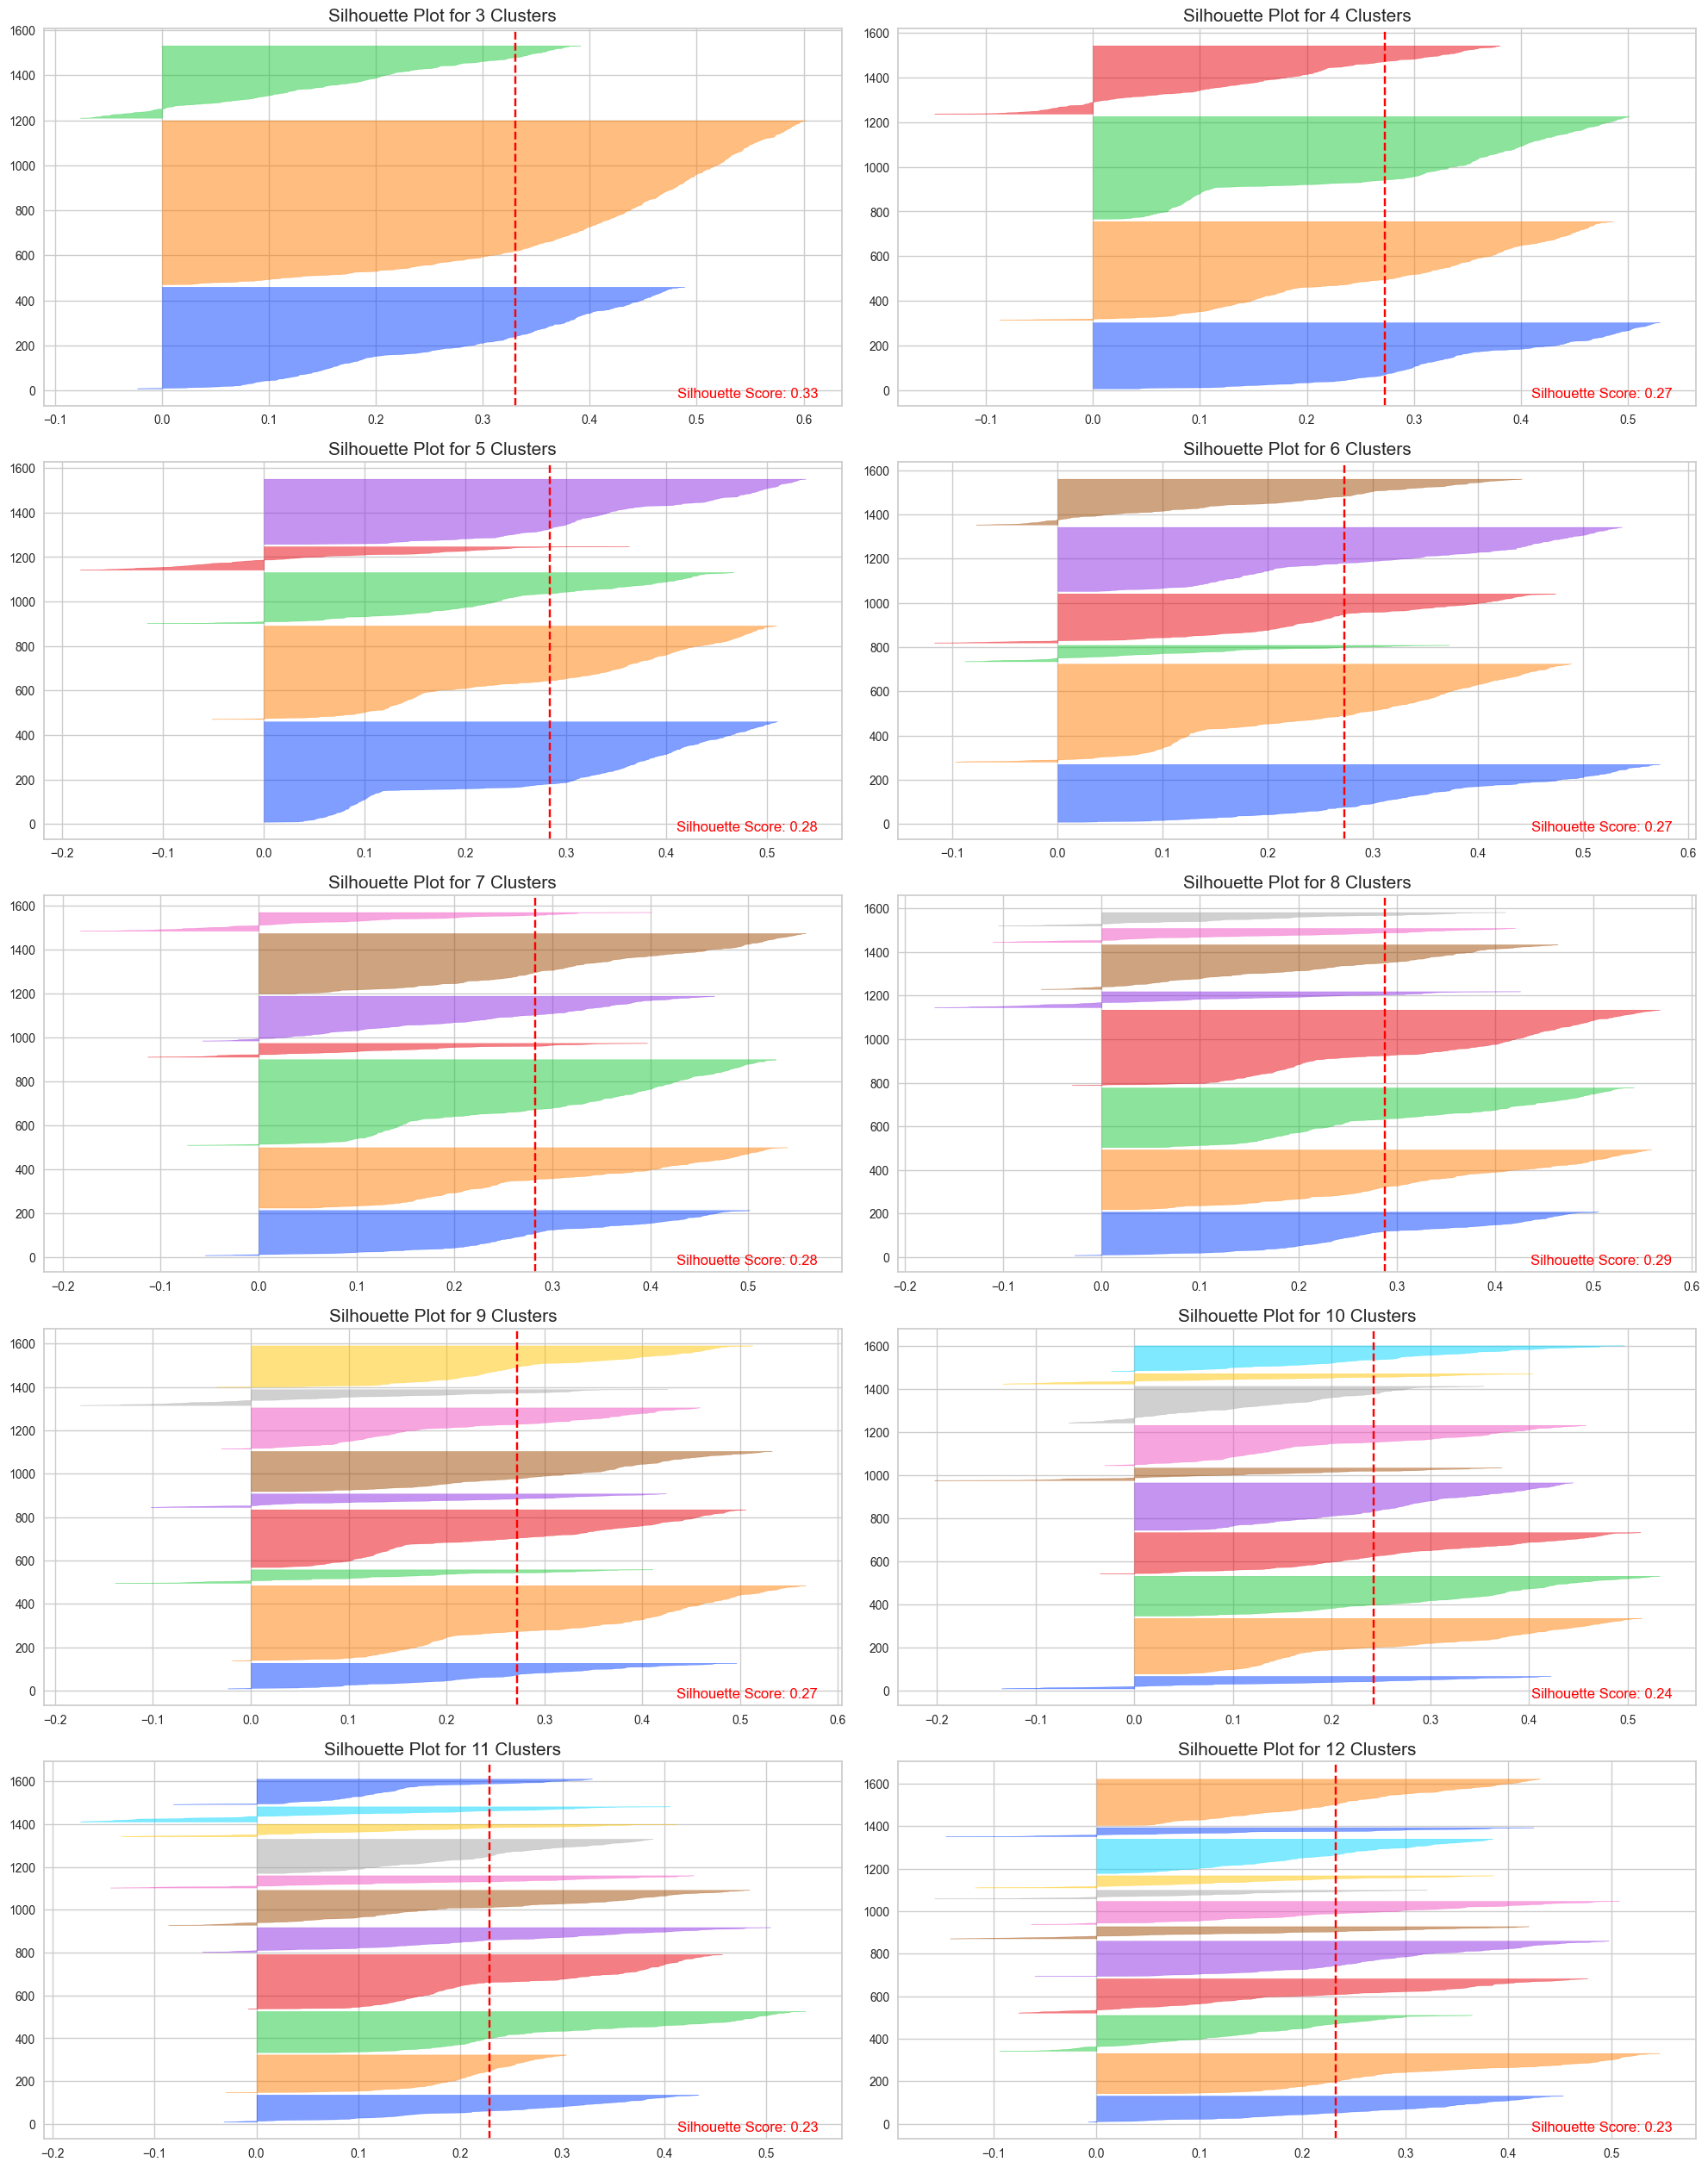

In [25]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

In [26]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

cluster_frequencies = Counter(kmeans.labels_)

label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

label_mapping = {v: k for k, v in {3: 0, 2: 1, 1: 2, 0: 3}.items()}

new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

customer_data_cleaned['cluster'] = new_labels

customer_data_pca['cluster'] = new_labels

### Clustering Evaluation

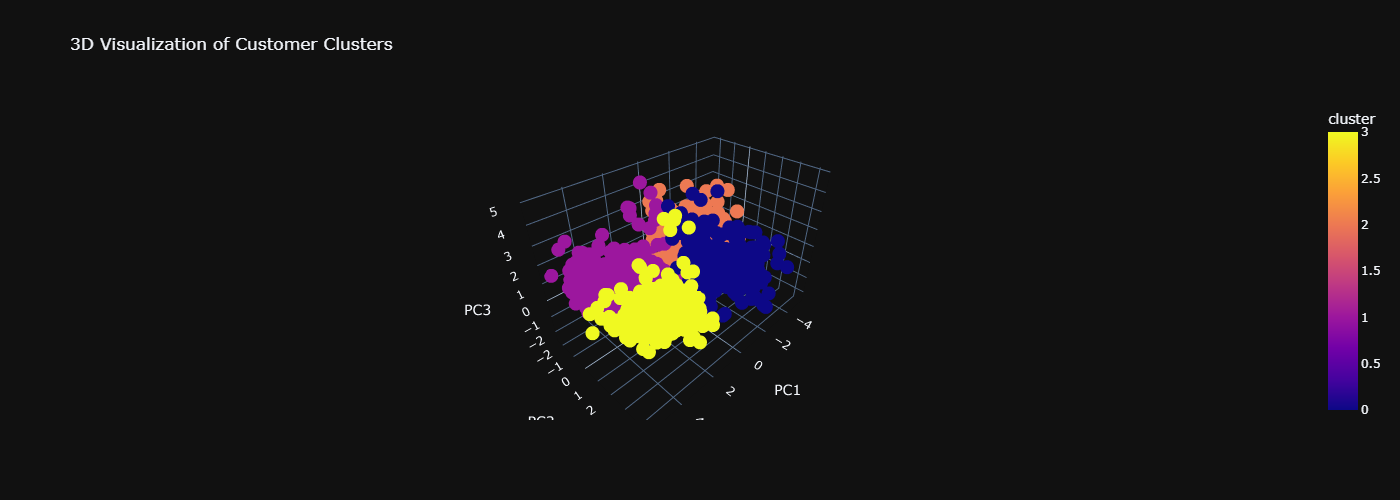

In [27]:
fig = px.scatter_3d(customer_data_pca, x='PC1', y='PC2', z='PC3', color='cluster',
                    title='3D Visualization of Customer Clusters')
fig.show()

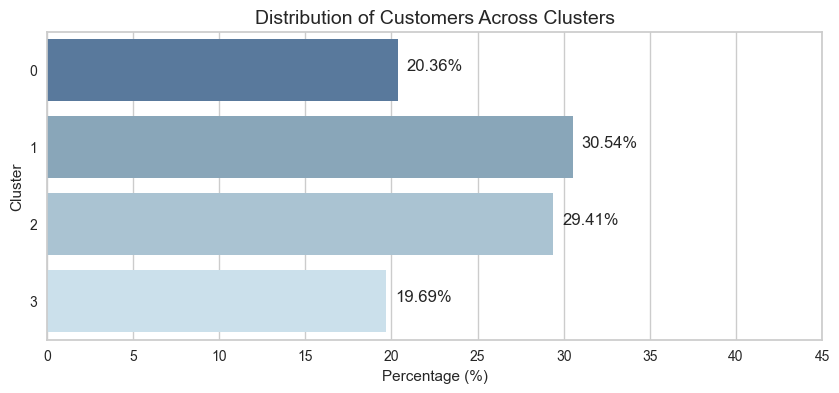

In [28]:
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=['#4e79a7', '#81a8c1', '#a3c5d9', '#c6e2f0'])

for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

plt.show()

In [29]:
num_observations = len(customer_data_pca)

X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

table_df = pd.DataFrame(table_data, columns=["Metric", "Value"])
table_df

,Metric,Value
0,Number of Observations,1503.000000
1,Silhouette Score,0.272956
2,Calinski Harabasz Score,724.390923
3,Davies Bouldin Score,1.418926


### Cluster Analysis and Profiling

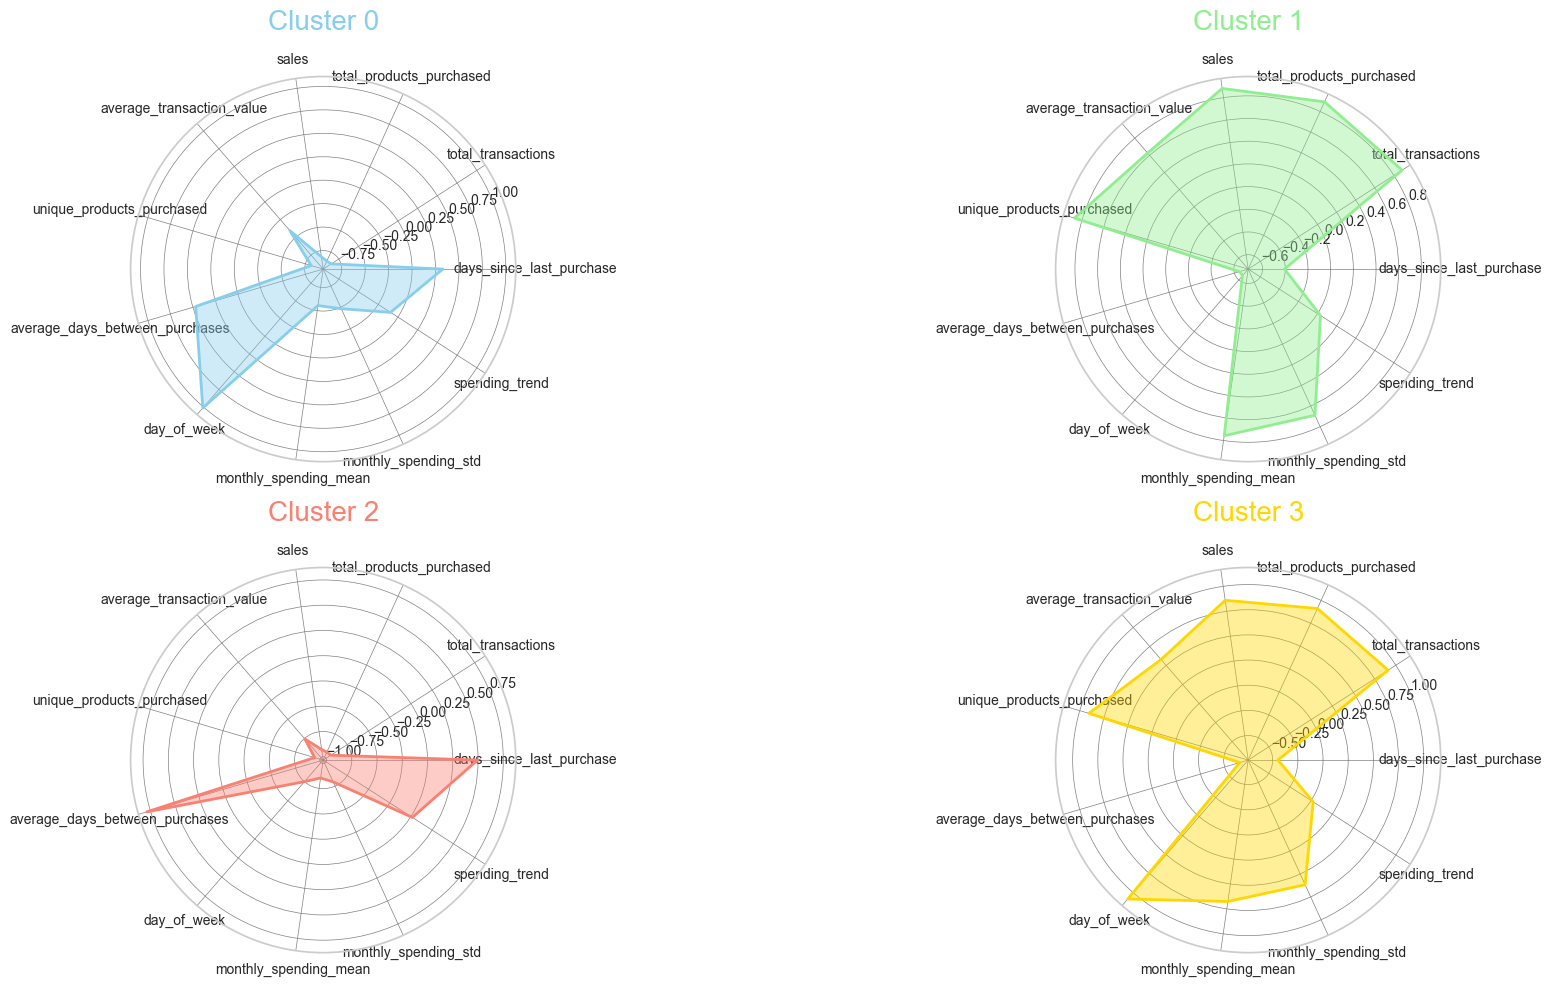

In [30]:
df_customer = customer_data_cleaned.set_index('customer_id')

scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

cluster_centroids = df_customer_standardized.groupby('cluster').mean()

def create_radar_chart(ax, angles, data, color, cluster):
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

num_clusters = len(cluster_centroids)
fig, ax = plt.subplots(figsize=(20, 10), nrows=2, ncols=2, subplot_kw=dict(polar=True))

colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

for i in range(num_clusters):
    row = i // 2  
    col = i % 2 
    
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]
    create_radar_chart(ax[row, col], angles, data, colors[i], i)

    ax[row, col].set_xticks(angles[:-1])
    ax[row, col].set_xticklabels(labels[:-1])
    ax[row, col].grid(color='grey', linewidth=0.5)

plt.tight_layout()
plt.show()


**Cluster 0 (Blue):** This group has low to moderate values across all metrics. Notably, they have longer periods since the last purchase and between purchases, indicating they are less frequent shoppers.

**Cluster 1 (Green):** This segment scores high on all metrics, suggesting these are high-value customers with frequent purchases, high sales, and a broad range of products purchased.

**Cluster 2 (Red):** Similar to Cluster 0, this group has low values across the metrics but seems to purchase slightly more frequently than Cluster 0 as indicated by the shorter average days between purchases.

**Cluster 3 (Yellow):** This cluster has moderate to high values on all metrics, but not as high as Cluster 1. They are relatively frequent shoppers with a good spending trend.